# Abstract gates


## Built-in standard gates
Besides constant gates, such as Hadamard, or CNOT, pyAQASM offers the possibilty to manipulate and declare abstract gates. pyAQASM natively supports 4 abstract gates: `RX`, `RY`, `RZ`, `PH`). You can see a definition of these gates [here](tutorials/lang/available_gates.ipynb).

In the following cell, you can see the difference between the abstract gate `RX` and its actual implementation.

In [5]:
from qat.lang.AQASM import Program, RX, Y, AbstractGate
import numpy as np

print(type(RX))
print(type(RX(np.pi)))

<class 'qat.lang.AQASM.gates.AbstractGate'>
<class 'qat.lang.AQASM.gates.ParamGate'>


Even if it's not define, we can still apply the gate to a `Program`.

In [8]:
pr = Program()
qr = pr.qalloc()
pr.apply(RX, qr)

However, circuit generation will fail since the gate has no signature.

In [9]:
try:
    cr = pr.to_circ()
except:
    print("Circuit generation failed")

Circuit generation failed


We should instead pass a proper initialization to the parameter.

pr2 = Program()
qr2 = pr2.qalloc()
pr2.apply(RX(2.3), qr2)

cr2 = pr2.to_circ()
%qatdisplay cr2

As an alternative, you can create variables.

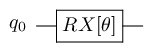

In [17]:
pr3 = Program()
qr3 = pr3.qalloc()
theta = pr3.new_var(float, "\\theta")
pr3.apply(RX(theta),qr)

cr3 = pr3.to_circ()
%qatdisplay cr3

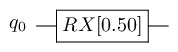

In [20]:
new_circuit = cr3.bind_variables({"\\theta": theta_val})
%qatdisplay new_circuit

Which comes handy when we want to simulate the same circuit many times with different parameters

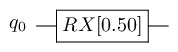

State |0> with amplitude (0.9689124217106447+0j)
State |1> with amplitude -0.24740395925452294j


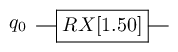

State |0> with amplitude (0.7316888688738209+0j)
State |1> with amplitude -0.6816387600233341j


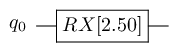

State |0> with amplitude (0.3153223623952687+0j)
State |1> with amplitude -0.9489846193555862j


In [21]:
from qat.qpus import PyLinalg
qpu = PyLinalg()

for theta_val in (.5, 1.5, 2.5):
    new_circuit = cr3.bind_variables({"\\theta": theta_val})
    %qatdisplay new_circuit
    res = qpu.submit(new_circuit.to_job())
    for sample in res:
        print(f"State {sample.state} with amplitude {sample.amplitude}")

## New abstract gates

Apart from those, new abstract gates can be defined.

Recall also that any gate can be modified using the following gate operators:
- *dag()*: Creates  the dagger of the parent Gate
- *ctrl()*: Creates a controlled version of the parent Gate
- *conj()*: Creates the complex conjugate of the parent Gate
- *trans()*: Creates the transpose of the parent Gate.

We will briefly see two different abstract gates.

In [34]:
prog = Program()
q = prog.qalloc(3)

Abstract gates do not require a particular matrix description: they are boxes with a name and a
signature.

In [35]:
my_gate = AbstractGate("mygate", # The name of the gate
                       [float], # Its signature: (here a single float)
                       arity=2) # Its arity 
prog.apply(my_gate(0.3), q[0], q[1])

A constant abstract gate (a CNOT)
The matrices lines and columns should be enumerated using the first qubit as
most significant (q)bit
For instance, the matrix corresponding to a CNOT gate whose first argument is the control qubit will look like:
$$
\begin{bmatrix}1&0&0&0\\0&1&0&0\\0&0&0&1\\0&0&1&0\end{bmatrix}$$


In [36]:
My_CNOT = AbstractGate("MY\_CNOT", [], arity=2,
                       matrix_generator=lambda : np.array([[1,0,0,0],
                                                           [0,1,0,0],
                                                           [0,0,0,1],
                                                           [0,0,1,0]]))

prog.apply(My_CNOT(), q[0], q[1])

Just a curiosity

In [37]:
print(type(My_CNOT))
print(type(My_CNOT()))

<class 'qat.lang.AQASM.gates.AbstractGate'>
<class 'qat.lang.AQASM.gates.ParamGate'>


We can treat those gates as any other standard gate.

In [38]:
prog.apply(My_CNOT().dag().ctrl(), q)

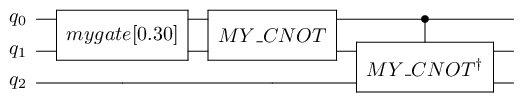

In [39]:
circ = prog.to_circ()
%qatdisplay circ

What if we want to associate a more complex function to an abstract gate? We will see briefly how to do it using `QRoutine`s.